In [2]:
import  torch, os
import  numpy as np
from    src.MiniImagenet import MiniImagenet
import  scipy.stats
from    torch.utils.data import DataLoader
from    torch.optim import lr_scheduler
import  random, sys, pickle
import  argparse

from src.meta import Meta

In [3]:
def mean_confidence_interval(accs, confidence=0.95):
    n = accs.shape[0]
    m, se = np.mean(accs), scipy.stats.sem(accs)
    h = se * scipy.stats.t._ppf((1 + confidence) / 2, n - 1)
    return m, h

In [4]:
def main():

    torch.manual_seed(222)
    torch.cuda.manual_seed_all(222)
    np.random.seed(222)

    print(args)

    config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [args["n_way"], 32 * 5 * 5])
    ]

    device = torch.device('cuda')
    maml = Meta(args, config).to(device)

    tmp = filter(lambda x: x.requires_grad, maml.parameters())
    num = sum(map(lambda x: np.prod(x.shape), tmp))
    print(maml)
    print('Total trainable tensors:', num)

    # batchsz here means total episode number
    mini = MiniImagenet('../miniimagenet/', mode='train', n_way=args["n_way"], k_shot=args["k_spt"],
                        k_query=args["k_qry"],
                        batchsz=10000, resize=args["imgsz"])
    mini_test = MiniImagenet('../miniimagenet/', mode='test', n_way=args["n_way"], k_shot=args["k_spt"],
                             k_query=args["k_qry"],
                             batchsz=100, resize=args["imgsz"])

    for epoch in range(args["training_iterations"]//10000):
        # fetch meta_batchsz num of episode each time
        db = DataLoader(mini, args["task_num"], shuffle=True, num_workers=1, pin_memory=True)

        for step, (x_spt, y_spt, x_qry, y_qry) in enumerate(db):

            x_spt, y_spt, x_qry, y_qry = x_spt.to(device), y_spt.to(device), x_qry.to(device), y_qry.to(device)

            accs = maml(x_spt, y_spt, x_qry, y_qry)

            if step % 30 == 0:
                print('step:', step, '\ttraining acc:', accs)

            if step % 500 == 0:  # evaluation
                db_test = DataLoader(mini_test, 1, shuffle=True, num_workers=1, pin_memory=True)
                accs_all_test = []

                for x_spt, y_spt, x_qry, y_qry in db_test:
                    x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0).to(device), y_spt.squeeze(0).to(device), \
                                                 x_qry.squeeze(0).to(device), y_qry.squeeze(0).to(device)

                    accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
                    accs_all_test.append(accs)

                # [b, update_step+1]
                accs = np.array(accs_all_test).mean(axis=0).astype(np.float16)
                print('Test acc:', accs)




In [5]:
if __name__ == '__main__':

#     argparser = argparse.ArgumentParser()
#     argparser.add_argument('--epoch', type=int, help='epoch number', default=60000)
#     argparser.add_argument('--n_way', type=int, help='n way', default=5)
#     argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=1)
#     argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=15)
#     argparser.add_argument('--imgsz', type=int, help='imgsz', default=84)
#     argparser.add_argument('--imgc', type=int, help='imgc', default=3)
#     argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=4)
#     argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
#     argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.01)
#     argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
#     argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)

#     args = argparser.parse_args("")


    args = {
        "training_iterations": 60000, #epoch
        "n_way": 5,                        # number of classes to choose between for each task
        "k_spt": 1,                        # k shot for support set (number of examples per class per task)
        "k_qry": 15,                       # k shot for query set (number of examples per class per task)
        "imgsz": 84,                       # image size
        "imgc": 3,                         # this isn't used anywhere????? no idea what it does???? they say its supposed to be 1 or 3...
        "task_num": 4,                     # meta model batch size
        "meta_lr": 1e-3,                   # meta model learning rate
        "update_lr": 0.01,                 # task specific model learning rate
        "update_step": 5,                  # task specific model training epochs
        "update_step_test": 10,            # task specific model testing epochs
#         "optimizer": ("adam", {"lr": 0.0001}),
#         "loss_func": "cross_entropy",
        "model_name": "MAML",
        "dataset_name": "mini_imagenet",
        "layer_definitions": None
    }

    main()


{'training_iterations': 60000, 'n_way': 5, 'k_spt': 1, 'k_qry': 15, 'imgsz': 84, 'imgc': 3, 'task_num': 4, 'meta_lr': 0.001, 'update_lr': 0.01, 'update_step': 5, 'update_step_test': 10, 'model_name': 'MAML', 'dataset_name': 'mini_imagenet', 'layer_definitions': None}
Meta(
  (net): Learner(
    conv2d:(ch_in:3, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:1, padding:0)
    flatten:()
    linear:(in:800, out:5)
    
  )
)
Total trainable tensors: 32901
shuffle DB :train, b:10000, 5-way, 1-shot, 15-query, resize:84
shuffle DB :test, b:100, 5-way

KeyboardInterrupt: 

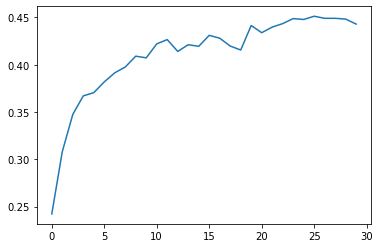

In [11]:
import matplotlib.pyplot as plt

scores = [0.2422, 0.308, 0.3474, 0.367, 0.3704, 0.3818, 0.3914, 0.3975, 0.409, 0.4072, 0.422, 0.4265, 0.414, 0.4211, 0.4194, 0.431, 0.428, 0.4197, 0.4155, 0.4414, 0.4338, 0.4397, 0.4434, 0.4487, 0.4478, 0.4512, 0.449, 0.449, 0.4482, 0.4429]
plt.plot(scores)

In [8]:
from src.models.mask_ops import apply_mask

def main():

    torch.manual_seed(222)
    torch.cuda.manual_seed_all(222)
    np.random.seed(222)

    print(args)

    config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [args.n_way, 32 * 5 * 5])
    ]

    device = torch.device('cuda')
    maml = Meta(args, config).to(device)
    mask = build_mask(model, {"name": "global"})

    tmp = filter(lambda x: x.requires_grad, maml.parameters())
    num = sum(map(lambda x: np.prod(x.shape), tmp))
    print(maml)
    print('Total trainable tensors:', num)

    # batchsz here means total episode number
    mini = MiniImagenet('../miniimagenet/', mode='train', n_way=args.n_way, k_shot=args.k_spt,
                        k_query=args.k_qry,
                        batchsz=10000, resize=args.imgsz)
    mini_test = MiniImagenet('../miniimagenet/', mode='test', n_way=args.n_way, k_shot=args.k_spt,
                             k_query=args.k_qry,
                             batchsz=100, resize=args.imgsz)

    for epoch in range(args.epoch//10000):
        # fetch meta_batchsz num of episode each time
        db = DataLoader(mini, args.task_num, shuffle=True, num_workers=1, pin_memory=True)

        for step, (x_spt, y_spt, x_qry, y_qry) in enumerate(db):

            x_spt, y_spt, x_qry, y_qry = x_spt.to(device), y_spt.to(device), x_qry.to(device), y_qry.to(device)

            accs = maml(mask, x_spt, y_spt, x_qry, y_qry)

            if step % 30 == 0:
                print('step:', step, '\ttraining acc:', accs)

            if step % 500 == 0:  # evaluation
                db_test = DataLoader(mini_test, 1, shuffle=True, num_workers=1, pin_memory=True)
                accs_all_test = []

                for x_spt, y_spt, x_qry, y_qry in db_test:
                    x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0).to(device), y_spt.squeeze(0).to(device), \
                                                 x_qry.squeeze(0).to(device), y_qry.squeeze(0).to(device)

                    accs = maml.finetunning(mask, x_spt, y_spt, x_qry, y_qry)
                    accs_all_test.append(accs)

                # [b, update_step+1]
                accs = np.array(accs_all_test).mean(axis=0).astype(np.float16)
                print('Test acc:', accs)




In [10]:
if __name__ == '__main__':

    argparser = argparse.ArgumentParser()
    argparser.add_argument('--epoch', type=int, help='epoch number', default=60000)
    argparser.add_argument('--n_way', type=int, help='n way', default=5)
    argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=1)
    argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=15)
    argparser.add_argument('--imgsz', type=int, help='imgsz', default=84)
    argparser.add_argument('--imgc', type=int, help='imgc', default=3)
    argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=4)
    argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
    argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.01)
    argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
    argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)

    args = argparser.parse_args("")

    main()


Namespace(epoch=60000, imgc=3, imgsz=84, k_qry=15, k_spt=1, meta_lr=0.001, n_way=5, task_num=4, update_lr=0.01, update_step=5, update_step_test=10)


TypeError: 'Namespace' object is not subscriptable